In [ ]:
#| default_exp deepfluoro

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from pathlib import Path

import h5py
import numpy as np
import torch
from diffdrr.data import read
from diffdrr.pose import RigidTransform
from diffdrr.utils import parse_intrinsic_matrix
from torchio import LabelMap, ScalarImage, Subject
from torchio.transforms.preprocessing import ToCanonical
from torchvision.transforms.functional import center_crop, gaussian_blur

from diffdrrdata.utils import load_file

The [`DeepFluoro`](https://github.com/rg2/DeepFluoroLabeling-IPCAI2020) dataset is a collection of pelvic CT and X-ray images from 6 cadaveric subjects from Johns Hopkins University. For each subject, there is

- One 3D CT volume
- One 3D labelmap for the CT
- Between 24-111 2D X-ray fluoroscopy images, depending on the subject

In total, the dataset comprises six CT volumes and 366 X-ray images (with ground truth camera poses).

In [ ]:
#| export
class DeepFluoroDataset(torch.utils.data.Dataset):
    """
    A `torch.utils.data.Dataset` that stores the imaging data for subjects
    in the `DeepFluoro` dataset and provides an iterator over the X-ray
    fluoroscopy images and associated poses for each subject. Imaging data
    can be passed to a `diffdrr.drr.DRR` to renderer DRRs from ground truth
    camera poses.
    """

    def __init__(
        self,
        id_number: int,  # Subject ID in {1, ..., 6}
        preprocess: bool = True,  # Preprocess raw X-rays
        batchless: bool = False,  # Return unbatched images and poses (e.g., to interface with a `torch.utils.data.DataLoader`)
        bone_attenuation_multiplier: float = 1.0,  # Scalar multiplier on density of high attenuation voxels
    ):
        super().__init__()

        # Load the subject
        (
            self.subject,
            self.projections,
            self.anatomical2world,
            self.world2camera,
            self.focal_len,
            self.height,
            self.width,
            self.delx,
            self.dely,
            self.x0,
            self.y0,
        ) = load(id_number, bone_attenuation_multiplier)

        self.preprocess = preprocess
        if self.preprocess:
            self.height -= 100
            self.width -= 100
        self.batchless = batchless

        # Miscellaneous transformation matrices for wrangling SE(3) poses
        self.flip_z = RigidTransform(
            torch.tensor(
                [
                    [0, -1, 0, 0],
                    [1, 0, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1],
                ]
            ).to(torch.float32)
        )
        self.rot_180 = RigidTransform(
            torch.tensor(
                [
                    [-1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                ]
            ).to(torch.float32)
        )
        self.reorient = RigidTransform(self.subject.reorient)

    def __len__(self):
        return len(self.projections)

    def __iter__(self):
        return iter(self[idx] for idx in range(len(self)))

    def __getitem__(self, idx):
        img = torch.from_numpy(self.projections[f"{idx:03d}/image/pixels"][:])
        pose = self.projections[f"{idx:03d}/gt-poses/cam-to-pelvis-vol"][:]
        pose = RigidTransform(torch.from_numpy(pose))
        pose = (
            self.flip_z.compose(self.world2camera.inverse())
            .compose(pose)
            .compose(self.anatomical2world)
        )
        if self.rot_180_for_up(idx):
            img = torch.rot90(img, k=2)
            pose = self.rot_180.compose(pose)
        pose = self.reorient.inverse().compose(pose)
        img = img.unsqueeze(0).unsqueeze(0)
        if self.preprocess:
            img = preprocess(img)
        if self.batchless:
            return img[0], pose.matrix[0]
        else:
            return img, pose

    def rot_180_for_up(self, idx):
        return self.projections[f"{idx:03d}/rot-180-for-up"][()]

In [ ]:
#| exporti
def parse_volume(subject, bone_attenuation_multiplier):
    # Get all parts of the volume
    volume = subject["vol/pixels"][:]
    volume = np.swapaxes(volume, 0, 2).copy()
    volume = torch.from_numpy(volume).unsqueeze(0)

    mask = subject["vol-seg/image/pixels"][:]
    mask = np.swapaxes(mask, 0, 2).copy()
    mask = torch.from_numpy(mask).unsqueeze(0)

    affine = np.eye(4)
    affine[:3, :3] = subject["vol/dir-mat"][:]
    affine[:3, 3:] = subject["vol/origin"][:]
    affine = torch.from_numpy(affine).to(torch.float32)

    defns = subject["vol-seg/labels-def"]
    defns = {idx: defns[f"{idx}"][()].decode() for idx in range(1, len(defns) + 1)}

    fiducials = torch.stack(
        [
            torch.from_numpy(subject[f"vol-landmarks/{key}"][()])
            for key in subject["vol-landmarks"].keys()
        ]
    ).permute(2, 0, 1)

    volume = ScalarImage(tensor=volume, affine=affine)
    labelmap = LabelMap(tensor=mask, affine=affine)

    # Package the subject
    subject = read(
        volume=volume,
        labelmap=labelmap,
        bone_attenuation_multiplier=bone_attenuation_multiplier,
        label_def=defns,
        fiducials=fiducials,
    )

    # Move the fiducials's isocenter to the origin in world coordinates
    isocenter = volume.get_center()
    anatomical2world = RigidTransform(
        torch.tensor(
            [
                [1.0, 0.0, 0.0, -isocenter[0]],
                [0.0, 1.0, 0.0, -isocenter[1]],
                [0.0, 0.0, 1.0, -isocenter[2]],
                [0.0, 0.0, 0.0, 1.0],
            ],
            dtype=torch.float32,
        )
    )

    return subject, anatomical2world


def parse_proj_params(f):
    proj_params = f["proj-params"]
    extrinsic = torch.from_numpy(proj_params["extrinsic"][:])
    world2camera = RigidTransform(extrinsic)
    intrinsic = torch.from_numpy(proj_params["intrinsic"][:])
    num_cols = proj_params["num-cols"][()]
    num_rows = proj_params["num-rows"][()]
    proj_col_spacing = float(proj_params["pixel-col-spacing"][()])
    proj_row_spacing = float(proj_params["pixel-row-spacing"][()])
    return (
        intrinsic,
        world2camera,
        num_cols,
        num_rows,
        proj_col_spacing,
        proj_row_spacing,
    )


def load(id_number, bone_attenuation_multiplier):
    f = load_file("ipcai_2020_full_res_data.h5")

    # Load dataset parameters
    (
        intrinsic,
        world2camera,
        num_cols,
        num_rows,
        proj_col_spacing,
        proj_row_spacing,
    ) = parse_proj_params(f)

    focal_len, x0, y0 = parse_intrinsic_matrix(
        intrinsic,
        num_rows,
        num_cols,
        proj_row_spacing,
        proj_col_spacing,
    )

    # Load subject data
    assert id_number in {1, 2, 3, 4, 5, 6}
    subject_id = [
        "17-1882",
        "18-1109",
        "18-0725",
        "18-2799",
        "18-2800",
        "17-1905",
    ][id_number - 1]
    subject = f[subject_id]
    projections = subject["projections"]
    subject, anatomical2world = parse_volume(subject, bone_attenuation_multiplier)

    return (
        subject,
        projections,
        anatomical2world,
        world2camera,
        focal_len,
        int(num_rows),
        int(num_cols),
        proj_row_spacing,
        proj_col_spacing,
        x0,
        y0,
    )


def preprocess(img, size=None, initial_energy=torch.tensor(65487.0)):
    """Convert X-ray fluoroscopy from the exponentiated form to the linear form."""
    img = center_crop(img, (1436, 1436))
    img = gaussian_blur(img, (5, 5), sigma=1.0)
    img = initial_energy.log() - img.log()
    img = (img - img.min()) / (img.max() - img.min())
    return img

If the `preprocess` flag is True, the `DeepFluoroDataset` will convert raw X-ray fluoroscopy images from their exponentated form to a linear form by recovering the line integral

$$L[i,j] = \log I_0 - \log I_f[i,j]$$

using the following steps:

1. Remove edge due to collimator (50 pixels)
2. Smooth the image to make less noisy
3. Subtract the log initial energy for each ray
4. Rescale image to [0, 1]

The `bone_attenuation_multiplier` behaves the same as in `DiffDRR` (for more details, see [here](https://vivekg.dev/DiffDRR/tutorials/introduction.html#changing-the-appearance-of-the-rendered-drrs)).

## Basic functionalities

Below, explain

- How to load the `DeepFluoro` dataset
- How to create a `diffdrr.drr.DRR` object from the `DeepFluoro` dataset
- A visualization of all the camera poses for all 6 subjects

### Initializing the `DeepFluoroDataset`

Initializing a `DeepFluoroDataset` returns an object containing a `torchio.Subject` that directly interfaces with the `diffdrr.drr.DRR` module. Additional intrinsic parameters (i.e., the imaging system's focal length, image dimensions, pixel spacings, and principal offsets) are parsed and returned upon initialization. 

In [ ]:
import matplotlib.pyplot as plt
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr
from torchvision.transforms.functional import resize

from diffdrrdata.deepfluoro import DeepFluoroDataset

The X-rays in the `DeepFluoro` dataset are 1436 × 1436 (after preprocessing), so to speed up DRR generation, we subsample the detector plane. Alternatively, to render full resolution DRRs in memory, one can use the `patch_size` argument in `diffdrr.drr.DRR` (for details, see [here](patch_size)).

In [ ]:
#| eval: false
deepfluoro = DeepFluoroDataset(id_number=1)

subsample = 8
height = deepfluoro.height // subsample
delx = deepfluoro.delx * subsample

drr = DRR(
    deepfluoro.subject,
    deepfluoro.focal_len,
    height,
    delx,
    x0=deepfluoro.x0,
    y0=deepfluoro.y0,
)

The `DeepFluoroDataset.__getitem__` method returns a real X-ray image and its associated ground-truth camera pose. This pose is a `diffdrr.pose.RigidTransform` object that can be passed direclty to the renderer.

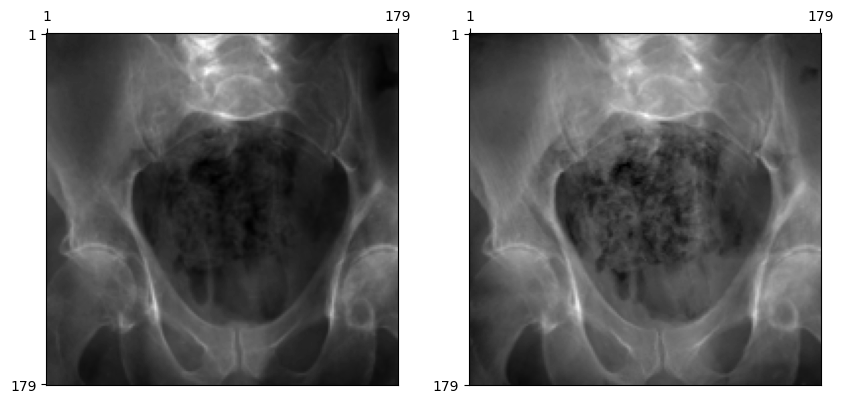

In [ ]:
#| eval: false
gt, pose = deepfluoro[0]
gt = resize(gt, height, antialias=True)
img = drr(pose)

plot_drr(torch.concat([gt, img]))
plt.show()

If we instead set `preprocess=False`, we can view the raw X-rays in their exponentiated form.

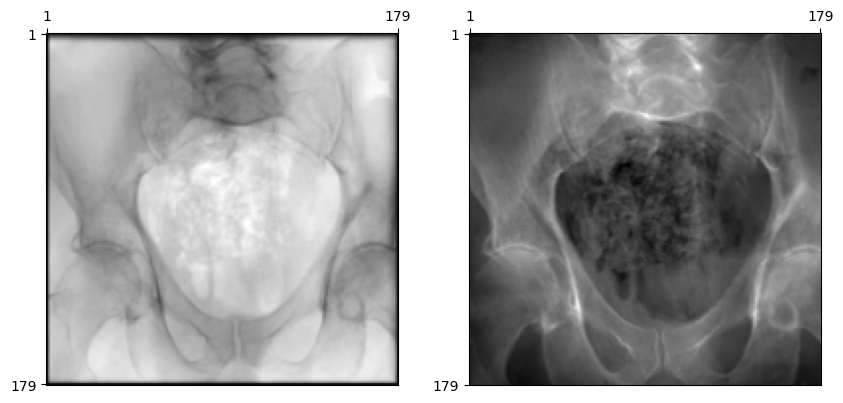

In [ ]:
#| code-fold: true
#| eval: false
deepfluoro = DeepFluoroDataset(id_number=1, preprocess=False)

drr = DRR(
    deepfluoro.subject,
    deepfluoro.focal_len,
    height,
    delx,
    x0=deepfluoro.x0,
    y0=deepfluoro.y0,
)

gt, pose = deepfluoro[0]
gt = resize(gt, height, antialias=True)
img = drr(pose)

plot_drr(torch.concat([gt, img]))
plt.show()

### Visualizing camera poses in 3D

We can use 3D plotting functions from `PyVista` available in `DiffDRR` to visualize the distributions of camera poses for the six subjects and 366 X-rays in the `DeepFluoro` dataset.

In [ ]:
import pyvista
from diffdrr.visualization import _make_camera_frustum_mesh, labelmap_to_mesh
from IPython.display import IFrame
from tqdm import tqdm

In [ ]:
#| code-fold: true
#| eval: false
plotter = pyvista.Plotter()


colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f"]
for idx in range(1, 7):
    deepfluoro = DeepFluoroDataset(idx)
    drr = DRR(
        deepfluoro.subject,
        deepfluoro.focal_len,
        deepfluoro.height // 8,
        deepfluoro.delx * 8,
        x0=deepfluoro.x0,
        y0=deepfluoro.y0,
    )

    if idx == 1:
        ct = labelmap_to_mesh(deepfluoro.subject)
        ct.clear_cell_data()
        plotter.add_mesh(ct)

    for img, pose in tqdm(deepfluoro, desc=f"Subject {idx}"):
        source, target = drr.detector(pose, None)
        source = source.squeeze().cpu().detach().numpy()
        target = (
            target.reshape(drr.detector.height, drr.detector.width, 3)
            .cpu()
            .detach()
            .numpy()
        )
        principal_ray = pyvista.Line(source, target.mean(axis=0).mean(axis=0))
        camera = _make_camera_frustum_mesh(source, target, size=0.05)
        plotter.add_mesh(camera, show_edges=False, color=colors[idx - 1])
        plotter.add_mesh(principal_ray, line_width=3, color=colors[idx - 1])

plotter.export_html("deepfluoro_camera_poses.html")

Performing Labeled Surface Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Cleaning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Subject 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.29it/s]


In this rendering, each rectangular frustum corresponds to the viewing angle for a particular X-ray and each color represents a different subject. For clarity, only the pelvis of the first subject is visualized.

In [ ]:
IFrame("deepfluoro_camera_poses.html", height=500, width=749)

### Other functionalities

The `DeepFluoro` dataset and its `DiffDRR` wrapper contain many other interesting features that are not covered in this short tutorial. These include

- Adjusting the `bone_attenuation_multipier`
- Fiducial markers in 2D and 3D related by perspective transforms
- Ground-truth 3D labelmaps that can be used to render 2D labelmaps
- Ground-truth 2D labelmaps for each X-ray image

For a complete overview of the data and features available in `DeepFluoro`, please check out [the original repository](https://github.com/rg2/DeepFluoroLabeling-IPCAI2020).

## Citations

If you use the `DeepFluoro` dataset in your work, please cite the authors' original publication:

```
@article{grupp2020automatic,
  title={Automatic annotation of hip anatomy in fluoroscopy for robust and efficient 2D/3D registration},
  author={Grupp, Robert B and Unberath, Mathias and Gao, Cong and Hegeman, Rachel A and Murphy, Ryan J and Alexander, Clayton P and Otake, Yoshito and McArthur, Benjamin A and Armand, Mehran and Taylor, Russell H},
  journal={International journal of computer assisted radiology and surgery},
  volume={15},
  pages={759--769},
  year={2020},
  publisher={Springer}
}
```

If you find `DiffDRR` or `DiffDRR-Datasets` useful for your work, please cite our paper

```
@inproceedings{gopalakrishnan2022fast,
  title={Fast auto-differentiable digitally reconstructed radiographs for solving inverse problems in intraoperative imaging},
  author={Gopalakrishnan, Vivek and Golland, Polina},
  booktitle={Workshop on Clinical Image-Based Procedures},
  pages={1--11},
  year={2022},
  organization={Springer}
}
```

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()